# Based on applicant form is the client going to be a good payer or  not?

## Imports

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pandas_profiling import ProfileReport

## Load Data

In [107]:
data_folder = Path("data")

In [108]:
df_credit_record = pd.read_csv(data_folder / 'credit_record.csv')
print(df_credit_record.shape)
df_credit_record.head(2)

(1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0


In [109]:
df_application_record = pd.read_csv(data_folder / 'application_record.csv')
print(df_application_record.shape)
df_application_record.head(2)

(438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


## Data Cleaning

In [110]:
# Credit status labels:
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days 
# C: paid off that month 
# X: No loan for the month

# Considering that passsing 1+ days ouverdue is a bad payment: 
# 0,1,2,3,4,5 -> bad payment -> 1
# C, X -> good payment -> 0

df_credit_record['BAD_PAYMENT'] = ~df_credit_record['STATUS'].isin(['C','X'])


In [111]:
# Merge bad payment info to application record
df_application_payment_label = df_application_record.join(df_credit_record.groupby('ID').BAD_PAYMENT.max(), on='ID', how='left')

In [112]:
df_application_payment_label.head(2)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,BAD_PAYMENT
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,True
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,True


In [113]:
df_application_payment_label.duplicated().sum()

0

In [114]:
df_application_payment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [115]:
df_application_payment_label.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
BAD_PAYMENT            402100
dtype: int64

In [116]:
# Since there is so many applicants without payment informations, let's exclude them out
df_application_payment_label= df_application_payment_label[~df_application_payment_label['BAD_PAYMENT'].isna()]
df_application_payment_label.shape

(36457, 19)

In [117]:
# Let's keep the occupation nulls to see if we can infere something about them


# Initial Feature engineering

In [118]:
# Change DAYS_BIRTH to AGE and 
df_application_payment_label['AGE'] = np.floor(-df_application_payment_label['DAYS_BIRTH'] / 365)

# Change DAYS_EMPLOYED to MONTHS_EMPLOYED if in the new column the number is negative than it means it is unemployed
df_application_payment_label['MONTHS_EMPLOYED'] = np.floor(-df_application_payment_label['DAYS_EMPLOYED'] / 30)

# Drop the columns converted
df_application_payment_label.drop(['DAYS_BIRTH','DAYS_EMPLOYED'], inplace=True, axis=1)

In [119]:
# Let's create a column with the average income per family member 
df_application_payment_label['AVG_INCOME_MEMBER'] = df_application_payment_label['AMT_INCOME_TOTAL'] / df_application_payment_label['CNT_FAM_MEMBERS']

# Exploratoty analysis

In [120]:
df_application_payment_label.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,BAD_PAYMENT,AGE,MONTHS_EMPLOYED,AVG_INCOME_MEMBER
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,True,32.0,151.0,213750.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,True,32.0,151.0,213750.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,True,58.0,37.0,56250.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,True,52.0,101.0,270000.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,False,52.0,101.0,270000.0


In [121]:
profile = ProfileReport(df_application_payment_label.drop(['ID'], axis=1), title="Profiling Report")
profile.to_widgets()


Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [122]:
## Insights from the profiling 
# 1 - CNT_CHILDREN is highly correlated with CNT_FAM_MEMBERS is highly correlated let's drop one of them
# 2 - FLAG_MOBIL is constant let's drop it
# 3 - FLAG_WORK_PHONE and FLAG_PHONE are highly correlated so lets drop FLAG_WORK_PHONE

In [123]:
df_application_payment_label.drop(['CNT_CHILDREN','FLAG_MOBIL','FLAG_WORK_PHONE'], inplace=True, axis=1)

## Exploratory analysis

In [124]:
# Analyse variables comparing with labels
bar_plot_cols = [col for col in df_application_payment_label.columns if (df_application_payment_label[col].dtype != 'float64') & (col != 'ID')]
hist_plot_cols = [col for col in df_application_payment_label.columns if (df_application_payment_label[col].dtype == 'float64') & (col != 'ID')]



In [125]:
# things I know i want to check:
# age vs label
# avg_income vs label 
# employment status vs label 
# Education type vs label
# education type vs label
# type income vs label 


In [126]:
df_application_payment_label.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'BAD_PAYMENT', 'AGE',
       'MONTHS_EMPLOYED', 'AVG_INCOME_MEMBER'],
      dtype='object')

<AxesSubplot:xlabel='AGE', ylabel='Probability'>

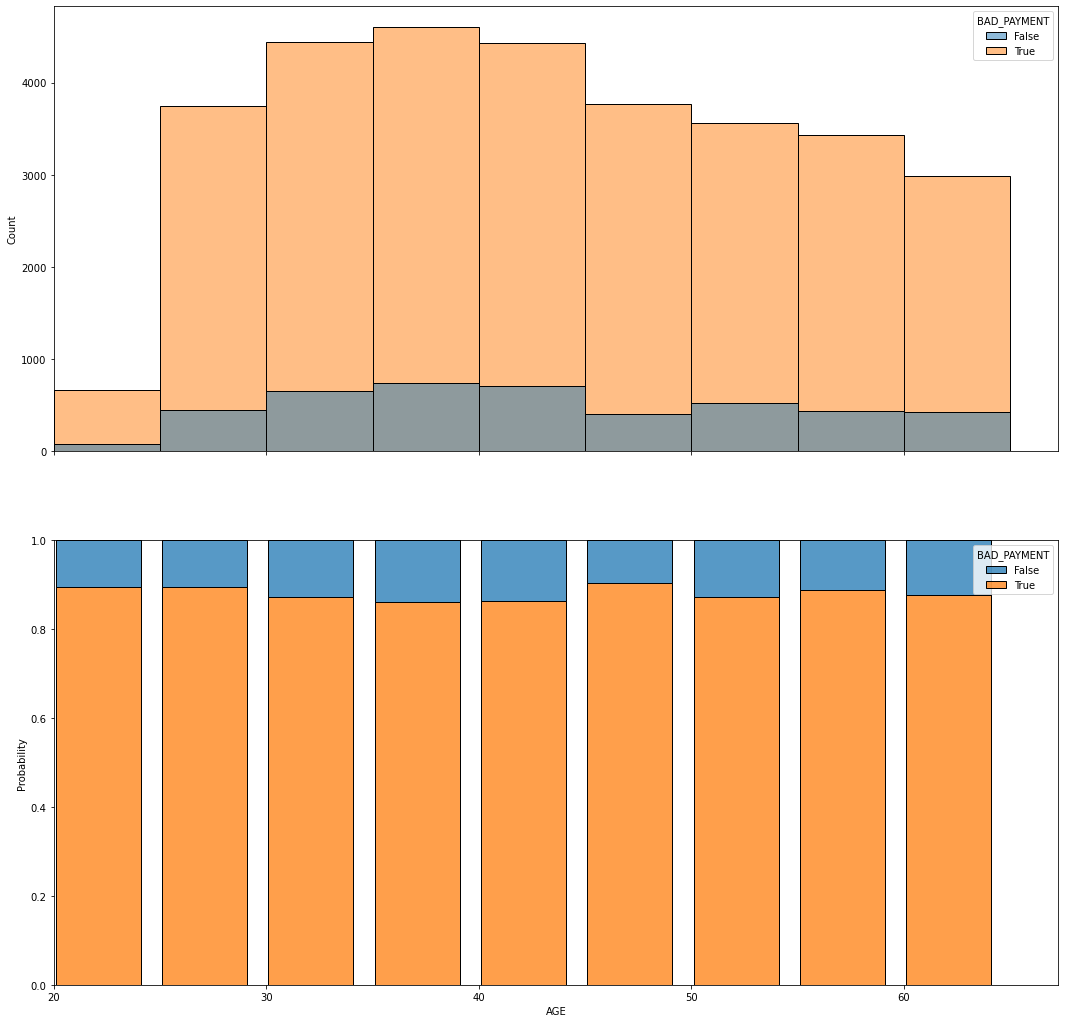

In [181]:
fig,  axs = plt.subplots(2, 1, sharex=True, figsize=(18,18))
sns.histplot(ax=axs[0],data=df_application_payment_label , x='AGE', hue='BAD_PAYMENT', bins=range(20,70,5))
sns.histplot(
    ax=axs[1],
    data=df_application_payment_label,
    x="AGE", hue="BAD_PAYMENT",
    bins=range(20,70,5),
    multiple="fill", stat="probability",
    discrete=False, shrink=.8
)

<AxesSubplot:xlabel='AVG_INCOME_MEMBER', ylabel='Count'>

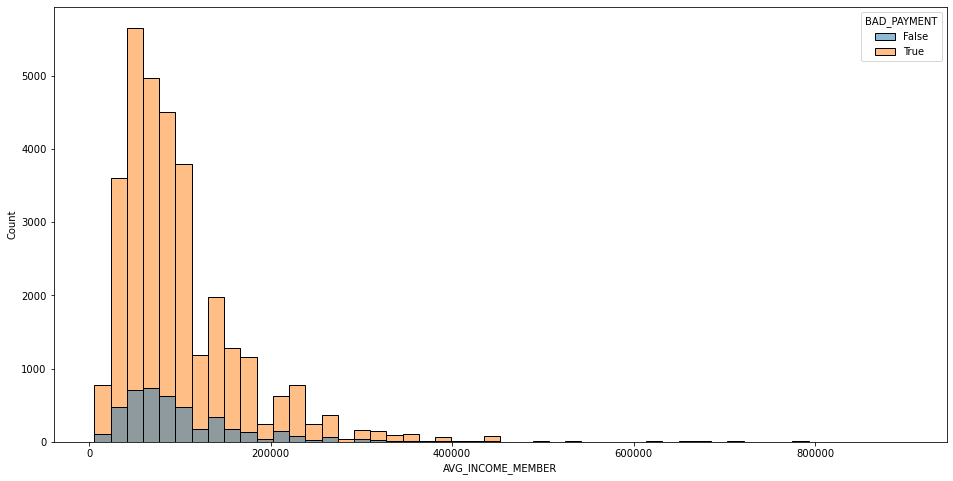

In [133]:
plt.figure(figsize=(16,8))
sns.histplot(data=df_application_payment_label , x='AVG_INCOME_MEMBER', hue='BAD_PAYMENT', bins=50)

<AxesSubplot:xlabel='MONTHS_EMPLOYED', ylabel='Count'>

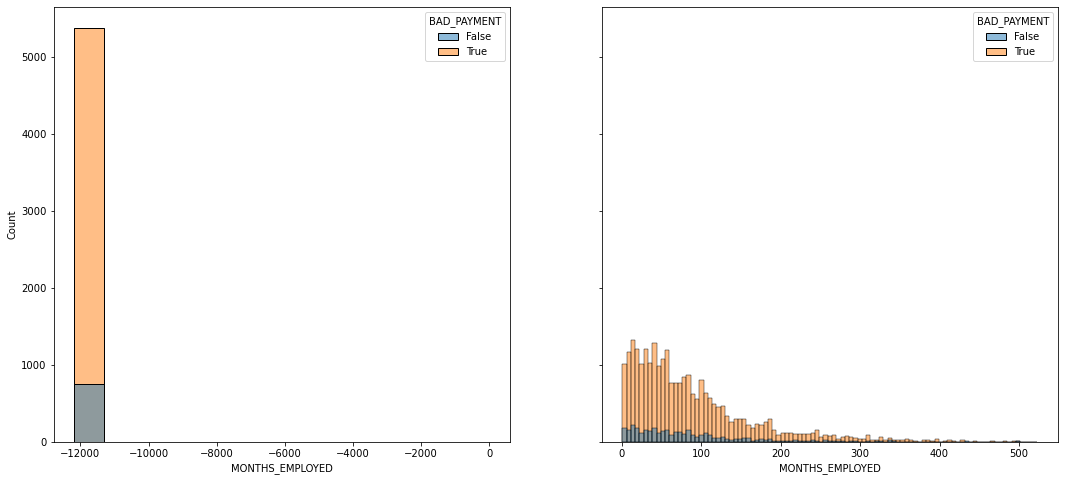

In [144]:
fig,  axs = plt.subplots(1, 2, sharey=True, figsize=(18,8))
sns.histplot(ax=axs[0],data=df_application_payment_label.loc[df_application_payment_label['MONTHS_EMPLOYED']<=0] , x='MONTHS_EMPLOYED', hue='BAD_PAYMENT')
sns.histplot(ax=axs[1], data=df_application_payment_label.loc[df_application_payment_label['MONTHS_EMPLOYED']>0] , x='MONTHS_EMPLOYED', hue='BAD_PAYMENT')


<AxesSubplot:xlabel='NAME_EDUCATION_TYPE', ylabel='count'>

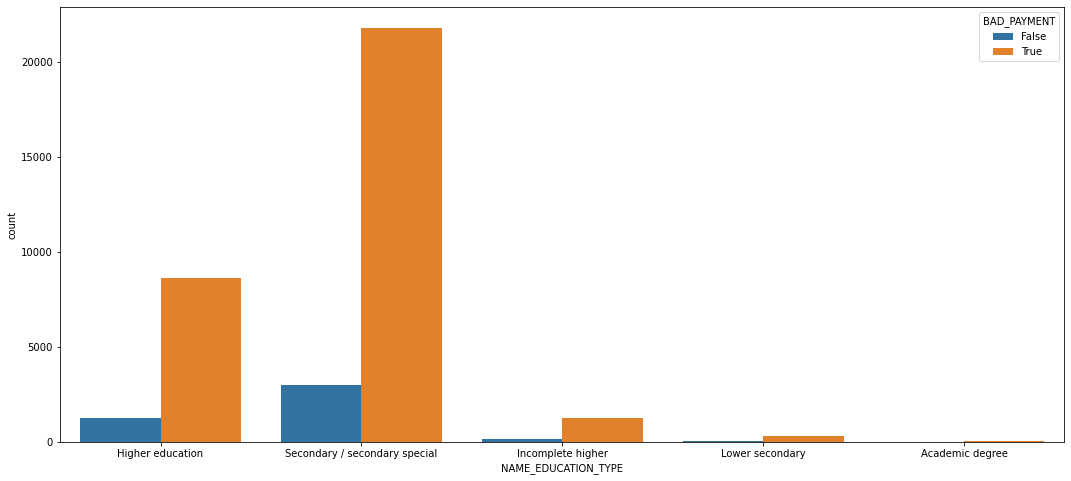

In [146]:
plt.figure(figsize=(18,8))
sns.countplot(data=df_application_payment_label,x='NAME_EDUCATION_TYPE',hue='BAD_PAYMENT')

In [ ]:
# pandas-profiling 
# univariaret
# bi variate with label 
# multi with variable
# feature selection (PCA, Factor analysis) - problema de pca e factor analysis é a explicabilidade

In [ ]:
# hist for some variables 

In [ ]:
## Numerical variabels
# histplots
# correlations

## categorical 
# bar charts
#pivot tables between label and category

In [ ]:
sns.pairplot(df_application_payment_label,hue='BAD_PAYMENT')